In [11]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import random
import collections

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

#backend = BasicAer.get_backend('unitary_simulator')
backend = BasicAer.get_backend('qasm_simulator')

# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

# CHSH Game
In this Jupyter Notebook we will simulate the CHSH Game and how a Quantum Strategy with Entangled qubits can always beat the 75% maximum success rate of any Classical Strategy

x,y are the values randomly sent by C (Charlie) to Alice and Bob and can be 0 or 1. 

a and b are the responses sent back to C by Alice and Bob. 

Game is won if (x AND y) is equal to (a XOR b).

## Classic Strategy for the CHSH Game
The best strategy is for Alice and Bob to agree on the same outcome and they will get 75% success rate at the most. In this code we clasically simulate the process

In [2]:
# x,y are the values randomly sent by C (Charlie) to Alice and Bob
# a,b are the responses sent back to C by A and B
# This function will return True or False under the Win conditions given x,y,a,b.
def CHSHwin (x,y,a,b):
        fromC = (x and y)
        receivedfromC = (a ^ b)
        
        return  fromC == receivedfromC

In [3]:
# x,y are the values randomly sent by C (Charlie) to Alice and Bob
# a,b are the responses sent back to C by A and B
# Bob and Alice best classic strategy 75% success is to agree to send always the same. 
# 0 or 1 do not make any difference as long as they are the same 
def AliceClassicStrategy (x):
      return  1

def BobClassicStrategy (y):
      return  1

In [4]:
N = 100000
success = 0
for i in range(N):
    x= random.randint(0,1)
    y= random.randint(0,1)
    result = CHSHwin(x,y,AliceClassicStrategy(x),BobClassicStrategy(y))
    if result == True:
        success += 1

print (100*success/N,"% Classic Success Rate")

75.051 % Classic Success Rate


## Classic Strategy Represented in Quantum Circuit
Now we are going to create a quantum circuit to simulate random selection of x, y.
Also we will use Qiskit simulation to get the results of the Classic Strategy

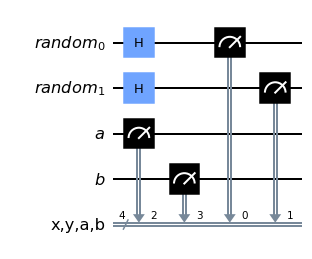

In [5]:
q = QuantumRegister(2, name="random")
c = ClassicalRegister(4, name="x,y,a,b")
a = QuantumRegister(1, name="a")
b = QuantumRegister(1, name="b")

qc = QuantumCircuit(q, a, b, c)

qc.h(q[0])
qc.h(q[1])
qc.measure(q[0],c[0])
qc.measure(q[1],c[1])
qc.measure(a[0],c[2])
qc.measure(b[0],c[3])

qc.draw('mpl')

The simulation gill give how many hits each of the x,y,a,b combination will give

In [6]:
# Execute the job 
job = backend.run(transpile(qc, backend),shots=8000)
counts = job.result().get_counts(qc)
print (counts)

{'0011': 2013, '0000': 1941, '0010': 2014, '0001': 2032}


Following function will calculate the success rate of the experiment ( % of experiments that CHSH "Won" )

In [7]:
# Extract the results and see which ones is a win in CHCS Game
def QuantumSuccessMetric(counts):
    successes = collections.defaultdict(int)
    failures = collections.defaultdict(int)
    
    for key, value in counts.items():
        minisuccess = CHSHwin (int(key[3]),int(key[2]),int(key[1]),int(key[0]))
        if minisuccess == True:
            successes[key[0]] += value
        else:
            failures[key[0]] += value
    return successes, failures

sim_successes, sim_failures = QuantumSuccessMetric(counts)

# PRINT percentage of the results were successful
print (100*(sum(sim_successes.values()) / sum(counts.values())),"% Classic Success Rate")

74.8375 % Classic Success Rate


## Now Lets explore the Quantum Strategy for CHSH Game with entangled Pairs
Both Alice and Bob will share an entangled qubit pair


Alice strategy will be to Measure in computational basis if she receives 0 ('x' = 0), and she will measure in $|+\rangle$ / $|-\rangle$ basis if she receives 1. Then she will return measurements result (0 or 1). Note that measuring in the $|+\rangle$ / $|-\rangle$ is like rotating the Bloch Sphere $\pi/2$ along the Y axis.


Bob strategy will be to rotate by an angle $\pi/4$ or $-\pi/4$ in the Bloch Sphere ( it is really $\pi/8$ rotation in Hilbert Space ) depending if he receives 0 or 1 in 'y' value from Charlie. Then he will measure in computational basis and will return measurements result (0 or 1)

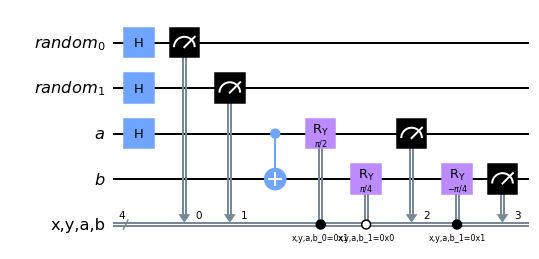

In [8]:
q = QuantumRegister(2, name="random")
c = ClassicalRegister(4, name="x,y,a,b")
a = QuantumRegister(1, name="a")
b = QuantumRegister(1, name="b")

qc = QuantumCircuit(q, a, b, c)

qc.h(q[0])
qc.h(q[1])
qc.measure(q[0],c[0])
qc.measure(q[1],c[1])

qc.h(a[0])
qc.cnot(a[0],b[0])

qc.ry(np.pi/2,a[0]).c_if(c[0],1)
qc.measure(a[0],c[2])

qc.ry(np.pi/4,b[0]).c_if(c[1],0)
qc.ry(-np.pi/4,b[0]).c_if(c[1],1)
qc.measure(b[0],c[3])


qc.draw('mpl')

The simulation gill give how many hits each of the x,y,a,b combination will give

In [9]:
# Execute the job 
job = backend.run(transpile(qc, backend),shots=9000)
counts = job.result().get_counts(qc)
print (counts)

{'0010': 986, '1110': 967, '0110': 155, '1011': 972, '0111': 976, '1101': 923, '0000': 958, '1100': 967, '1010': 151, '0001': 977, '0100': 158, '0101': 169, '1111': 159, '1000': 158, '0011': 158, '1001': 166}


Following function will calculate the success rate of the experiment ( % of experiments that CHSH "Won" )

In [10]:
sim_successes, sim_failures = QuantumSuccessMetric(counts)

# PRINT percentage of the results were successful
print ('\033[1;3m',100*(sum(sim_successes.values()) / sum(counts.values())),"% Quantum CHSH Success Rate")

 85.84444444444445 % Quantum CHSH Success Rate


As we can see the result of the experiment is near to the theoretical value $ {\textstyle \cos ^{2}\left({\frac {\pi }{8}}\right)=85.35533\%\approx 85\%}$